In [1]:
import glob, os, sys
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
import xarray as xr

Importing the `re` module to allow the use of [regular expressions](https://docs.python.org/3/library/re.html) to search the `Information` files for metadata.

In [2]:
import re

Allow plotting of matplotlib figures inline in the Jupyter notebook. The `inline` parameter might be changed to `widget` to allow resizing and zooming in figures.

In [3]:
%matplotlib widget

In [4]:
currentdir = os.getcwd()

In [5]:
currentdir

'/storage/emulated/0/Documents/Pydroid3/jupyter notebooks'

In [6]:
data_path = '/storage/emulated/0/Documents/Pydroid3/Raman/'
sys.path.append(data_path)

Using `glob` to filter files within a folder.

# Reading the map and metadata

In [7]:
glob.glob(data_path + '*')

['/storage/emulated/0/Documents/Pydroid3/Raman/G csucskalibracio_ABC_grafithoz.FLG_36--Scan Piezo--023--Information.txt',
 '/storage/emulated/0/Documents/Pydroid3/Raman/FLG36.MK_FLG_ABC_36--Scan Piezo--013--Information.txt',
 '/storage/emulated/0/Documents/Pydroid3/Raman/G csucs kalibracio_ABC grafithoz.FLG_36--Scan Piezo--023--Spec.Data 1.txt',
 '/storage/emulated/0/Documents/Pydroid3/Raman/FLG36.MK_FLG_ABC_36--Scan Piezo--013--Spec.Data 1.txt']

In [8]:
for path in glob.glob(data_path + '*Information*'):
    print(path)

/storage/emulated/0/Documents/Pydroid3/Raman/G csucskalibracio_ABC_grafithoz.FLG_36--Scan Piezo--023--Information.txt
/storage/emulated/0/Documents/Pydroid3/Raman/FLG36.MK_FLG_ABC_36--Scan Piezo--013--Information.txt


In [9]:
for path in glob.glob(data_path + '*Data*'):
    print(path)

/storage/emulated/0/Documents/Pydroid3/Raman/G csucs kalibracio_ABC grafithoz.FLG_36--Scan Piezo--023--Spec.Data 1.txt
/storage/emulated/0/Documents/Pydroid3/Raman/FLG36.MK_FLG_ABC_36--Scan Piezo--013--Spec.Data 1.txt


Load the large map, around 156 MB.

In [10]:
map_path = glob.glob(data_path + '*ABC_36*' + '*Data*')[0]

In [11]:
map_path

'/storage/emulated/0/Documents/Pydroid3/Raman/FLG36.MK_FLG_ABC_36--Scan Piezo--013--Spec.Data 1.txt'

In [12]:
m = np.loadtxt(map_path, skiprows=19, encoding='latin1')

In [13]:
m.shape

(1600, 7470)

## Extracting info from metadata, using regular expressions

The spectra are just one after the other, so one needs to infer the size in pixels from the `Information` file, containing the metadata. It is a good idea to use `with` so that the file will be closed even if there is some error during execution, otherwise a close command needs to be also included after the `read()`.

In [14]:
info_path = glob.glob(data_path + '*ABC_36*' + '*Information*')[0]

In [15]:
info_path

'/storage/emulated/0/Documents/Pydroid3/Raman/FLG36.MK_FLG_ABC_36--Scan Piezo--013--Information.txt'

In [16]:
with open(info_path, mode='r', encoding='latin1') as infofile:
    metadata  = infofile.read()

In [17]:
metadata

'MK_FLG_ABC_36--Scan Piezo--013\n\nGeneral:\nSystem ID:\t100-1100-758\nStart Time:\t14:16:33\nStart Date:\t2023. május 25., csütörtök\nDuration:\t1h 13m 13s\nUser Name:\tWitec\nSample Name:\tMK_FLG_ABC_36\nConfiguration:\tRaman CCD1\n\nImage Scan:\nPoints per Line:\t97\nLines per Image:\t77\nScan Width [µm]:\t97.000\nScan Height [µm]:\t77.000\nScan Origin X [µm]:\t2.368\nScan Origin Y [µm]:\t21.902\nScan Origin Z [µm]:\t0.000\nZ-Rotation [°]:\t-0.500\nScan Speed [s/Line]:\t48.500\nRetrace Speed [s/Line]:\t0.500\nIntegration Time [s]:\t0.5\n\nUHTS300M:\nExcitation Wavelength [nm]:\t487.986\nGrating:\tG1: 600 g/mm BLZ=500nm\nCenter Wavelength [nm]:\t540.752\nSpectral Center [rel. 1/cm]:\t1999.637\n\nDU970_BV:\nWidth [Pixels]:\t1600\nHeight [Pixels]:\t200\nTemperature [°C]:\t-59\nCycle Time [s]:\t0.50000\nCamera Serial Nr.:\t13899\nAD Converters:\tAD1 (16Bit)\nOutput Amplifier:\tEMCCD Gain\nVertical Shift Speed [µs]:\t[4.95]\nHorizontal Shift Speed [MHz]:\t0.05\nPreamplifier Gain:\t1\nEMC

Search the info file for the size in pixels and microns of the map. The below regular expression, looks for `Points per Line:` followed by a tab character and followed by any number of digits (`\d+`).

In [18]:
pixel_x_match = re.findall('(?<=Points per Line:\t)-?\d+', metadata)

In [19]:
pixel_x_match

['97']

Let's turn it into an integer.

In [20]:
pixel_x = int(pixel_x_match[0])

In [21]:
pixel_x

97

Let's do a similar thing for the lines per image.

In [22]:
pixel_y_match = re.findall('(?<=Lines per Image:\t)-?\d+', metadata)

In [23]:
pixel_y = int(pixel_y_match[0])

In [24]:
pixel_y

77

## Reshaping the data

The data in the oringinal text file is such that the 1600 pixel CCD camera data (Raman shifts) are on one axis and the spectra are not arranged into an *x pixel* $\times$ *y pixel* array, but are arranged one after the other. We need to rearrange this for better handling and plotting later.

In [25]:
m.shape

(1600, 7470)

In [26]:
77*97

7469

We can see that the shape of the imported Raman data is one larger than the `pixel_x * pixel_y` size of the data in pixels. The one extra line holds the Raman shift information in the values given during export from the wip file. Let's find the Raman shift by plotting the first or last 1600 long data array from the imported map.

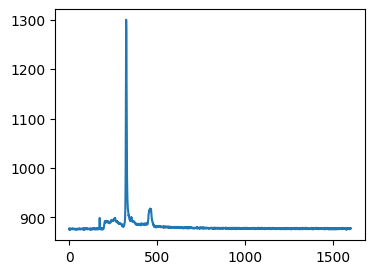

In [27]:
pl.subplots(1, 1, figsize=(4, 3))
pl.plot(m[:, -1])

The last one looks like a Raman spectrum, bu vs the indexes. We can also see the Rayleigh peak, so we expect a good number of negative values in the Raman shift array. Let's look at the first array.

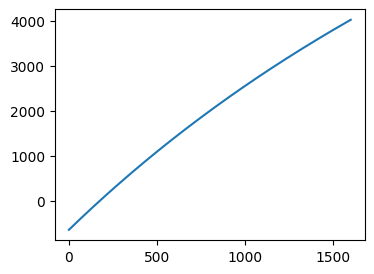

In [28]:
pl.subplots(1, 1, figsize=(4, 3))
pl.plot(m[:, 0])

This looks more like a Raman shift. Lets plot one of the Raman spectra as a function of this.

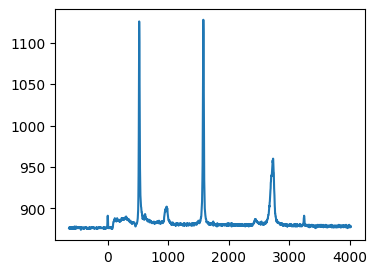

In [29]:
pl.subplots(1, 1, figsize=(4, 3))
pl.plot(m[:, 0], m[:, 5000])

We'll make a new array called `ramanshift` from the first column, which will be used later in constructing the `xarray` DataArray.

In [30]:
ramanshift = m[:, 0]

Ok, now we have the Raman spectra. We need to reorganize the `1600 x 7470` size array into a `pixel_x * pixel_y` array. For this we can use the `reshape()` function of numpy. however, we need to take out the first column, which are the Raman shift values. For this we can use slicing `m[:, 1:]`

In [31]:
m[:, 1:].shape

(1600, 7469)

Indeed this gives the right size of the array in terms of pixels per line and lines per pixel.

In [32]:
pixel_x * pixel_y

7469

In [33]:
ramanmap = np.reshape(m[:, 1:], (m.shape[0], pixel_x, pixel_y))

In [34]:
ramanmap.shape

(1600, 97, 77)

Let's try a "quick and dirty" plot of the Raman intensity to see if we rearranged the data in the right way. The previous rearrangement assumes that the first 97 datapoints from 7469 is the first "horizontal" line of the Raman map. We need to check if this is true. For plotting a 2D array, we can use the `imshow()` function of matplotlib. For this we need to slice into the now 3D array `ramanmap` over the first index.

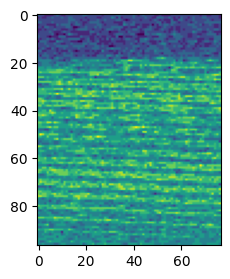

In [35]:
pl.subplots(1, 1, figsize=(4, 3))
pl.imshow(ramanmap[800, :, :])

This doesn't look good. We probably have mixed up the lines per pixel and the pixels per line (`pixel_x`, `pixel_y`). Let's switch them up, and see what we get.

In [36]:
ramanmap = np.reshape(m[:, 1:], (m.shape[0], pixel_y, pixel_x))

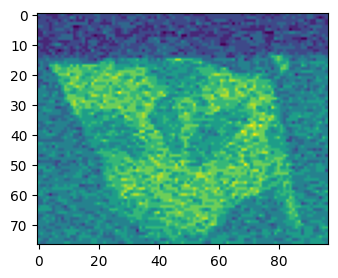

In [37]:
pl.subplots(1, 1, figsize=(4, 3))
pl.imshow(ramanmap[800, :, :])

Ok. This looks much better. Now we know that in the `reshape()`, `pixel_y` comes before `pixel_x`.

# Building an xarray Dataarray from the info we have

## Getting more metadata

Before moving on it would be good to also extract the size in microns of the image. We can do this similarly to the above using regular expressions and the `findall()` function.

In [38]:
metadata

'MK_FLG_ABC_36--Scan Piezo--013\n\nGeneral:\nSystem ID:\t100-1100-758\nStart Time:\t14:16:33\nStart Date:\t2023. május 25., csütörtök\nDuration:\t1h 13m 13s\nUser Name:\tWitec\nSample Name:\tMK_FLG_ABC_36\nConfiguration:\tRaman CCD1\n\nImage Scan:\nPoints per Line:\t97\nLines per Image:\t77\nScan Width [µm]:\t97.000\nScan Height [µm]:\t77.000\nScan Origin X [µm]:\t2.368\nScan Origin Y [µm]:\t21.902\nScan Origin Z [µm]:\t0.000\nZ-Rotation [°]:\t-0.500\nScan Speed [s/Line]:\t48.500\nRetrace Speed [s/Line]:\t0.500\nIntegration Time [s]:\t0.5\n\nUHTS300M:\nExcitation Wavelength [nm]:\t487.986\nGrating:\tG1: 600 g/mm BLZ=500nm\nCenter Wavelength [nm]:\t540.752\nSpectral Center [rel. 1/cm]:\t1999.637\n\nDU970_BV:\nWidth [Pixels]:\t1600\nHeight [Pixels]:\t200\nTemperature [°C]:\t-59\nCycle Time [s]:\t0.50000\nCamera Serial Nr.:\t13899\nAD Converters:\tAD1 (16Bit)\nOutput Amplifier:\tEMCCD Gain\nVertical Shift Speed [µs]:\t[4.95]\nHorizontal Shift Speed [MHz]:\t0.05\nPreamplifier Gain:\t1\nEMC

In [39]:
size_x_match = re.findall('(?<=Scan Width \[µm\]:\t)-?\d+\.\d+', metadata)
size_y_match = re.findall('(?<=Scan Height \[µm\]:\t)-?\d+\.\d+', metadata)

In [40]:
print(size_x_match, size_y_match)

['97.000'] ['77.000']


In this case the regular expression is a bit different from the one used above to search for the pixel size. One difference is that the string we are looking for has `[` parenthesis. These are regular expression commands, thus they need to be "escaped" using the `\` character. This way they are interpreted as the character \[, not a command. We are also looking for a floating number, separated by `.`. Thus the number format we are looking for is any number of digits: `\d+`, followed by a `.` character (this also needs to be escaped), and finally any number of digits as the decimals: `\d+`.

Let's turn the strings into floating point numbers.

In [41]:
size_x = float(size_x_match[0])
size_y = float(size_y_match[0])

In [42]:
size_x, size_y

(97.0, 77.0)

Let's get more metadata, such as the:
- date of measurement
- start time of measurement
- sample name
- positioner position
- laser energy
- integration time
- objective
- obective magnification
- grating used

We can keep these as strings.

In [43]:
metadata_date_match = re.findall('(?<=Start Date:\t)-?.+', metadata)

In [44]:
metadata_date_match

['2023. május 25., csütörtök']

In [45]:
metadata_time_match = re.findall('(?<=Start Time:\t)-?.+', metadata)

In [46]:
metadata_time_match

['14:16:33']

In [47]:
metadata_name_match = re.findall('(?<=Sample Name:\t)-?.+', metadata)

In [48]:
metadata_name_match

['MK_FLG_ABC_36']

In [49]:
metadata_laser_match = re.findall('(?<=Excitation Wavelength \[nm\]:\t)-?.+', metadata)

In [50]:
metadata_laser_match

['487.986']

In [51]:
metadata_itime_match = re.findall('(?<=Integration Time \[s\]:\t)-?.+', metadata)

In [52]:
metadata_itime_match

['0.5']

In [53]:
metadata_grating_match = re.findall('(?<=Grating:\t)-?.+', metadata)

In [54]:
metadata_grating_match

['G1: 600 g/mm BLZ=500nm']

In [55]:
metadata_objname_match = re.findall('(?<=Objective Name:\t)-?.+', metadata)

In [56]:
metadata_objname_match

['Zeiss EC Epiplan-Neofluar Dic 50x / 0.8']

In [57]:
metadata_objmagn_match = re.findall('(?<=Objective Magnification:\t)-?.+', metadata)

In [58]:
metadata_objmagn_match

['50.0']

In [59]:
metadata_positioner_match = re.findall('(?<=Position X \[µm\]:\t)-?.+', metadata)

In [60]:
metadata_positioner_match

['-1470.000']

In [61]:
metadata_positioner_x = float(metadata_positioner_match[0])

In [62]:
metadata_positioner_x

-1470.0

In [63]:
metadata_positioner_match = re.findall('(?<=Position Y \[µm\]:\t)-?.+', metadata)

In [64]:
metadata_positioner_y = float(metadata_positioner_match[0])

In [65]:
metadata_positioner_y

1170.6

## Building the xarray DataArray

In [66]:
ramanmap.shape

(1600, 77, 97)

Let's put the numpy array data into the xarray DataArray.

In [67]:
ramanxr = xr.DataArray(ramanmap)

In [68]:
ramanxr

<xarray.DataArray (dim_0: 1600, dim_1: 77, dim_2: 97)>
array([[[875., 875., 875., ..., 874., 874., 874.],
        [875., 875., 874., ..., 875., 875., 875.],
        [875., 875., 875., ..., 875., 875., 875.],
        ...,
        [877., 877., 876., ..., 876., 877., 876.],
        [877., 877., 877., ..., 876., 876., 876.],
        [877., 877., 876., ..., 876., 876., 876.]],

       [[875., 875., 875., ..., 874., 874., 874.],
        [874., 875., 875., ..., 875., 875., 875.],
        [876., 875., 875., ..., 876., 874., 876.],
        ...,
        [876., 876., 877., ..., 878., 877., 877.],
        [877., 877., 877., ..., 877., 877., 876.],
        [877., 876., 877., ..., 876., 878., 878.]],

       [[875., 875., 875., ..., 875., 876., 876.],
        [874., 874., 875., ..., 875., 875., 876.],
        [875., 875., 875., ..., 875., 876., 875.],
        ...,
...
        ...,
        [877., 877., 877., ..., 876., 877., 877.],
        [878., 878., 877., ..., 877., 877., 877.],
        [878., 877., 877., ..., 877., 877., 877.]],

       [[874., 874., 875., ..., 875., 875., 875.],
        [875., 875., 875., ..., 875., 875., 875.],
        [875., 875., 876., ..., 875., 875., 876.],
        ...,
        [877., 877., 877., ..., 877., 877., 878.],
        [878., 877., 877., ..., 877., 878., 878.],
        [877., 877., 878., ..., 876., 878., 877.]],

       [[875., 875., 875., ..., 876., 876., 874.],
        [875., 874., 874., ..., 876., 876., 876.],
        [875., 876., 875., ..., 876., 875., 875.],
        ...,
        [877., 878., 878., ..., 877., 877., 877.],
        [877., 876., 876., ..., 877., 877., 877.],
        [878., 879., 877., ..., 877., 877., 878.]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

Let's add some dimension names instead of `dim_0`, etc.

In [69]:
ramanxr = xr.DataArray(ramanmap, dims = ['ramanshift', 'height', 'width'])

In [70]:
ramanxr

<xarray.DataArray (ramanshift: 1600, height: 77, width: 97)>
array([[[875., 875., 875., ..., 874., 874., 874.],
        [875., 875., 874., ..., 875., 875., 875.],
        [875., 875., 875., ..., 875., 875., 875.],
        ...,
        [877., 877., 876., ..., 876., 877., 876.],
        [877., 877., 877., ..., 876., 876., 876.],
        [877., 877., 876., ..., 876., 876., 876.]],

       [[875., 875., 875., ..., 874., 874., 874.],
        [874., 875., 875., ..., 875., 875., 875.],
        [876., 875., 875., ..., 876., 874., 876.],
        ...,
        [876., 876., 877., ..., 878., 877., 877.],
        [877., 877., 877., ..., 877., 877., 876.],
        [877., 876., 877., ..., 876., 878., 878.]],

       [[875., 875., 875., ..., 875., 876., 876.],
        [874., 874., 875., ..., 875., 875., 876.],
        [875., 875., 875., ..., 875., 876., 875.],
        ...,
...
        ...,
        [877., 877., 877., ..., 876., 877., 877.],
        [878., 878., 877., ..., 877., 877., 877.],
        [878., 877., 877., ..., 877., 877., 877.]],

       [[874., 874., 875., ..., 875., 875., 875.],
        [875., 875., 875., ..., 875., 875., 875.],
        [875., 875., 876., ..., 875., 875., 876.],
        ...,
        [877., 877., 877., ..., 877., 877., 878.],
        [878., 877., 877., ..., 877., 878., 878.],
        [877., 877., 878., ..., 876., 878., 877.]],

       [[875., 875., 875., ..., 876., 876., 874.],
        [875., 874., 874., ..., 876., 876., 876.],
        [875., 876., 875., ..., 876., 875., 875.],
        ...,
        [877., 878., 878., ..., 877., 877., 877.],
        [877., 876., 876., ..., 877., 877., 877.],
        [878., 879., 877., ..., 877., 877., 878.]]])
Dimensions without coordinates: ramanshift, height, width

Let's make some coordinates for all the dimensions. For this we will use `linspace` from numpy, to create labels for all in the indexes along the three coordinates. The Raman shift is already ready, so we can use that.

In [71]:
ramanxr = xr.DataArray(ramanmap, dims = ['ramanshift', 'height', 'width'], coords = {'ramanshift': ramanshift})

In [72]:
ramanmap.shape

(1600, 77, 97)

In [73]:
height = np.linspace(0, size_y, num = pixel_y)
width = np.linspace(0, size_x, num = pixel_x)

In [74]:
ramanxr = xr.DataArray(ramanmap,
                       dims = ['ramanshift', 'height', 'width'],
                       coords = {
                           'ramanshift': ramanshift,
                           'height': height,
                           'width': width
                       })

Now we have proper coordinates for the size and Raman shift of our data.

In [76]:
ramanxr

<xarray.DataArray (ramanshift: 1600, height: 77, width: 97)>
array([[[875., 875., 875., ..., 874., 874., 874.],
        [875., 875., 874., ..., 875., 875., 875.],
        [875., 875., 875., ..., 875., 875., 875.],
        ...,
        [877., 877., 876., ..., 876., 877., 876.],
        [877., 877., 877., ..., 876., 876., 876.],
        [877., 877., 876., ..., 876., 876., 876.]],

       [[875., 875., 875., ..., 874., 874., 874.],
        [874., 875., 875., ..., 875., 875., 875.],
        [876., 875., 875., ..., 876., 874., 876.],
        ...,
        [876., 876., 877., ..., 878., 877., 877.],
        [877., 877., 877., ..., 877., 877., 876.],
        [877., 876., 877., ..., 876., 878., 878.]],

       [[875., 875., 875., ..., 875., 876., 876.],
        [874., 874., 875., ..., 875., 875., 876.],
        [875., 875., 875., ..., 875., 876., 875.],
        ...,
...
        ...,
        [877., 877., 877., ..., 876., 877., 877.],
        [878., 878., 877., ..., 877., 877., 877.],
        [878., 877., 877., ..., 877., 877., 877.]],

       [[874., 874., 875., ..., 875., 875., 875.],
        [875., 875., 875., ..., 875., 875., 875.],
        [875., 875., 876., ..., 875., 875., 876.],
        ...,
        [877., 877., 877., ..., 877., 877., 878.],
        [878., 877., 877., ..., 877., 878., 878.],
        [877., 877., 878., ..., 876., 878., 877.]],

       [[875., 875., 875., ..., 876., 876., 874.],
        [875., 874., 874., ..., 876., 876., 876.],
        [875., 876., 875., ..., 876., 875., 875.],
        ...,
        [877., 878., 878., ..., 877., 877., 877.],
        [877., 876., 876., ..., 877., 877., 877.],
        [878., 879., 877., ..., 877., 877., 878.]]])
Coordinates:
  * ramanshift  (ramanshift) float64 -639.5 -635.7 ... 4.017e+03 4.019e+03
  * height      (height) float64 0.0 1.013 2.026 3.039 ... 74.97 75.99 77.0
  * width       (width) float64 0.0 1.01 2.021 3.031 ... 93.97 94.98 95.99 97.0

Let's give the intensity some units.

In [125]:
ramanxr.attrs['units'] = 'au'
ramanxr.attrs['long_name'] = 'Raman intensity'

Let's do some slicing and plotting. For example let's use the `sel()` function of xarray select the Raman intensity values at 1582 cm%^{-1}% and plot the intensity on a density plot.

For more options it is worth reading the xarray [documentation](https://xarray-test.readthedocs.io/en/latest/data-structures.html).

In [126]:
gintensity = ramanxr.sel(ramanshift = 1582, method = 'nearest')

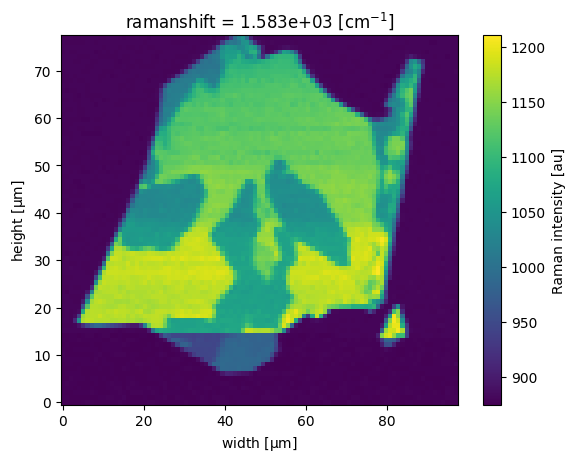

In [128]:
gintensity.plot()

AMAZING!

<mark>**The width and height need to be switched, compared to the Witec Project output!**</mark>

## Adding the rest of the metadata to the DataArray

Let's get more metadata, such as the:
- date of measurement
- start time of measurement
- sample name
- positioner position
- laser energy
- integration time
- objective
- obective magnification
- grating used

We can keep these as strings.

In [80]:
ramanxr.attrs['sample name'] = metadata_name_match[0]
ramanxr.attrs['laser excitation'] = metadata_laser_match[0] + ' nm'
ramanxr.attrs['time of measurement'] = metadata_time_match[0]
ramanxr.attrs['date of measurement'] = metadata_date_match[0]
ramanxr.attrs['integration time'] = metadata_itime_match[0] + ' s'
ramanxr.attrs['sample positioner X'] = metadata_positioner_x
ramanxr.attrs['sample positioner Y'] = metadata_positioner_y
ramanxr.attrs['objective name'] = metadata_objname_match[0]
ramanxr.attrs['objective magnification'] = metadata_objmagn_match[0] + 'x'
ramanxr.attrs['grating'] = metadata_grating_match[0]

In [81]:
ramanxr

<xarray.DataArray (ramanshift: 1600, height: 77, width: 97)>
array([[[875., 875., 875., ..., 874., 874., 874.],
        [875., 875., 874., ..., 875., 875., 875.],
        [875., 875., 875., ..., 875., 875., 875.],
        ...,
        [877., 877., 876., ..., 876., 877., 876.],
        [877., 877., 877., ..., 876., 876., 876.],
        [877., 877., 876., ..., 876., 876., 876.]],

       [[875., 875., 875., ..., 874., 874., 874.],
        [874., 875., 875., ..., 875., 875., 875.],
        [876., 875., 875., ..., 876., 874., 876.],
        ...,
        [876., 876., 877., ..., 878., 877., 877.],
        [877., 877., 877., ..., 877., 877., 876.],
        [877., 876., 877., ..., 876., 878., 878.]],

       [[875., 875., 875., ..., 875., 876., 876.],
        [874., 874., 875., ..., 875., 875., 876.],
        [875., 875., 875., ..., 875., 876., 875.],
        ...,
...
        ...,
        [877., 877., 877., ..., 876., 877., 877.],
        [878., 878., 877., ..., 877., 877., 877.],
        [878., 877., 877., ..., 877., 877., 877.]],

       [[874., 874., 875., ..., 875., 875., 875.],
        [875., 875., 875., ..., 875., 875., 875.],
        [875., 875., 876., ..., 875., 875., 876.],
        ...,
        [877., 877., 877., ..., 877., 877., 878.],
        [878., 877., 877., ..., 877., 878., 878.],
        [877., 877., 878., ..., 876., 878., 877.]],

       [[875., 875., 875., ..., 876., 876., 874.],
        [875., 874., 874., ..., 876., 876., 876.],
        [875., 876., 875., ..., 876., 875., 875.],
        ...,
        [877., 878., 878., ..., 877., 877., 877.],
        [877., 876., 876., ..., 877., 877., 877.],
        [878., 879., 877., ..., 877., 877., 878.]]])
Coordinates:
  * ramanshift  (ramanshift) float64 -639.5 -635.7 ... 4.017e+03 4.019e+03
  * height      (height) float64 0.0 1.013 2.026 3.039 ... 74.97 75.99 77.0
  * width       (width) float64 0.0 1.01 2.021 3.031 ... 93.97 94.98 95.99 97.0
Attributes:
    units:                    Raman intensity
    sample name:              MK_FLG_ABC_36
    laser excitation:         487.986 nm
    time of measurement:      14:16:33
    date of measurement:      2023. május 25., csütörtök
    integration time:         0.5 s
    sample positioner X:      -1470.0
    sample positioner Y:      1170.6
    objective name:           Zeiss EC Epiplan-Neofluar Dic 50x / 0.8
    objective magnification:  50.0x
    grating:                  G1: 600 g/mm BLZ=500nm

We will also add some attributes to the coordinates, namely the units. The strings in the unit attributes can have LaTeX code, between `$` signs. 

In [133]:
ramanxr.coords['ramanshift'].attrs['units'] = 'cm$^{-1}$'
ramanxr.coords['ramanshift'].attrs['long name'] = 'Raman shift'
ramanxr.coords['width'].attrs['units'] = '$\mathrm{\mu m}$'
ramanxr.coords['width'].attrs['long_name'] = 'width'
ramanxr.coords['height'].attrs['units'] = '$\mathrm{\mu m}$'
ramanxr.coords['height'].attrs['long_name'] = 'height'

In [134]:
ramanxr.coords['ramanshift'].attrs['units']

'cm$^{-1}$'

Now the `plot()` function will add the coordinate units to the axis labels.

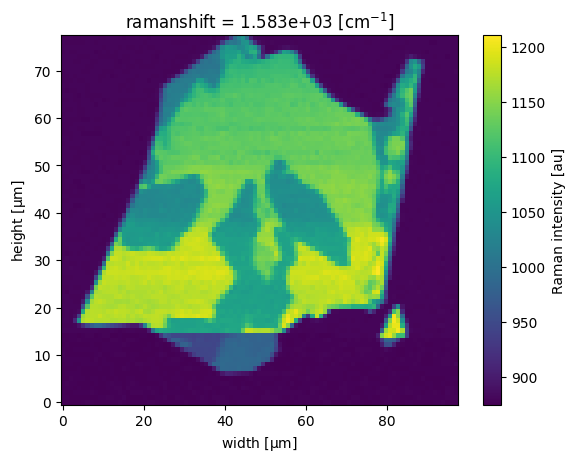

In [135]:
ramanxr.sel(ramanshift = 1583, method = 'nearest').plot()

Let's do a Witec Project style sum filter using by taking the mean of the Raman intensity in a certain range of Raman shifts.

First we'll plot the area of the G peak from one of the positions.

(1530.0, 1650.0)

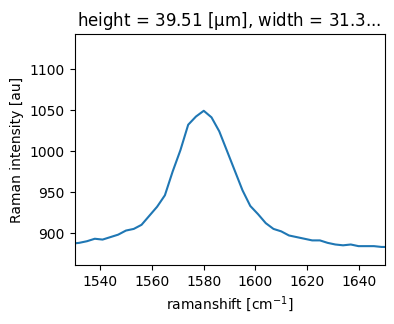

In [136]:
pl.subplots(1, 1, figsize = (4, 3))
ramanxr.sel(height = 40, width = 31, method = 'nearest').plot()
pl.xlim([1530, 1650])

One can mostly use the options for any matplotlib figure, see above.

Let's do the summation.

First we will select the values we want to sum over, using the `slice` method.

In [150]:
g_area = ramanxr.sel(ramanshift = slice(1540, 1620))

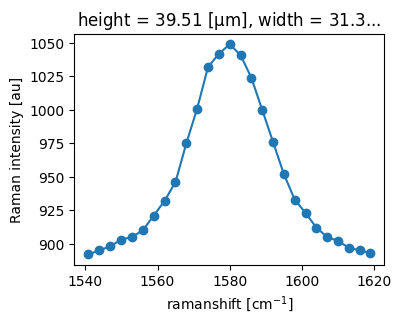

In [140]:
pl.subplots(1, 1, figsize = (4, 3))
g_area.sel(height = 40, width = 31, method = 'nearest').plot(marker = 'o')

Now, lets sum over the `ramanshift` dimension, using the function `sum()`.

In [142]:
g_sum = g_area.sum(dim = 'ramanshift')

In [143]:
g_sum

<xarray.DataArray (height: 77, width: 97)>
array([[23661., 23669., 23668., ..., 23677., 23676., 23679.],
       [23668., 23660., 23660., ..., 23684., 23687., 23680.],
       [23674., 23679., 23679., ..., 23678., 23684., 23684.],
       ...,
       [23732., 23733., 23729., ..., 23739., 23737., 23738.],
       [23729., 23725., 23727., ..., 23738., 23734., 23730.],
       [23727., 23729., 23725., ..., 23733., 23726., 23731.]])
Coordinates:
  * height   (height) float64 0.0 1.013 2.026 3.039 ... 73.96 74.97 75.99 77.0
  * width    (width) float64 0.0 1.01 2.021 3.031 ... 93.97 94.98 95.99 97.0

Now we only have height and width data, and the values in the array are the summed intensities in the range we selected. Let's plot it on a density plot.

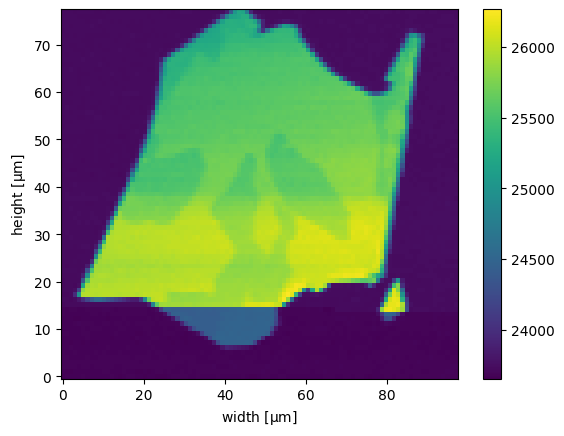

In [144]:
g_sum.plot()

Let's plot a line section along one of the height values, next to the density plot. For this we can just will specify the axis to plot on, using `ax`.

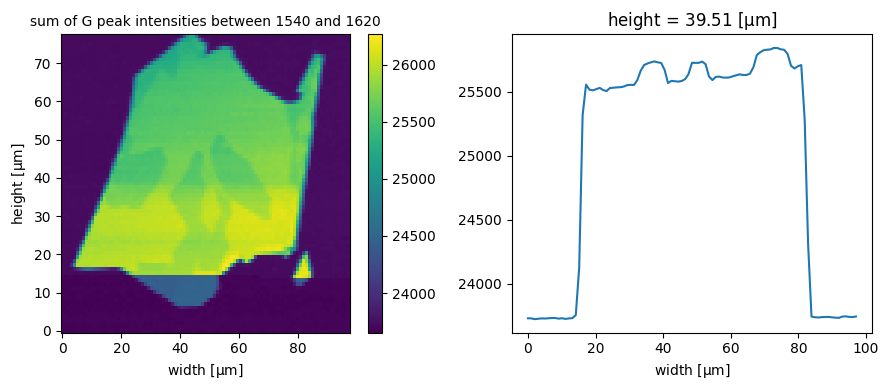

In [160]:
fig, [ax0, ax1] = pl.subplots(1, 2, figsize = (9, 4))
g_sum.plot(ax = ax0)
g_sum.sel(height = 40, method = 'nearest').plot(ax = ax1)
ax0.set_title('sum of G peak intensities between 1540 and 1620', fontsize = 10)
pl.tight_layout()

Added some matplotlib options in the above graph, such as giving a title to the left figure.

Moving on. Let's plot the area ratios for the "bottom" and "top" of the 2D peak. For added contrast, we will subtract the ~800 count background signal by hand now. Ideally this needs to be done by fitting each spectrum.

Let's keep track which parts we are selecting by plotting the 2D peak bottom and top parts on the same graph.

In [183]:
bottom = ramanxr.sel(ramanshift = slice(2650, 2715)).sel(width = 30, height = 30, method = 'nearest') - 800

In [189]:
top = ramanxr.sel(ramanshift = slice(2715, 2780)).sel(width = 30, height = 30, method = 'nearest') - 800

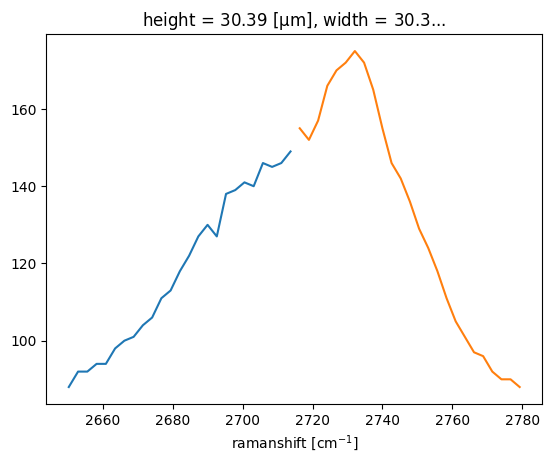

In [185]:
bottom.plot()
top.plot()

We can see that the roughly 800 count background was subtracted. So quite intuitively one can just subtract a value from the `xarray` object. We can also do arithmetic with two xarray objects as demonstrated below.

We can now plot the ratio of the bottom and top parts, which is also an `xarray` object.

In [199]:
twod_bottom = ramanxr.sel(ramanshift = slice(2650, 2715)) - 800
twod_bottom = twod_bottom.sum(dim = 'ramanshift')
twod_top = ramanxr.sel(ramanshift = slice(2715, 2780)) - 800
twod_top = twod_top.sum(dim = 'ramanshift')

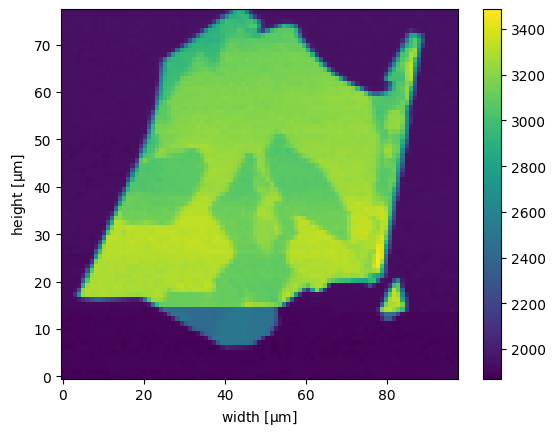

In [200]:
twod_top.plot()

In [201]:
twod_ratio = twod_top / twod_bottom

Now that we have two `xarray` objects, containing the sum of the 2D peak bottom part and the top part, we can take the ratio of these, which will also be an xarray object! How cool is that?!

In [202]:
twod_ratio

<xarray.DataArray (height: 77, width: 97)>
array([[0.99681866, 1.00319149, 1.0010627 , ..., 0.99525817, 0.99947341,
        0.99947202],
       [0.99787573, 0.99841017, 0.99946978, ..., 1.00158479, 1.        ,
        1.00317797],
       [0.9978836 , 0.9984127 , 0.99894292, ..., 0.99526066, 1.00158562,
        1.00052854],
       ...,
       [0.99742931, 0.99948427, 0.9989696 , ..., 0.99538225, 0.99948507,
        0.99845838],
       [1.0015456 , 1.0015448 , 0.9984552 , ..., 0.9989696 , 0.99897013,
        0.99794239],
       [1.        , 0.99691517, 1.00206505, ..., 1.0005152 , 0.99948639,
        1.        ]])
Coordinates:
  * height   (height) float64 0.0 1.013 2.026 3.039 ... 73.96 74.97 75.99 77.0
  * width    (width) float64 0.0 1.01 2.021 3.031 ... 93.97 94.98 95.99 97.0

Let's plot it.

Text(0.5, 1.0, 'ratio of the 2D peak bottom and top area')

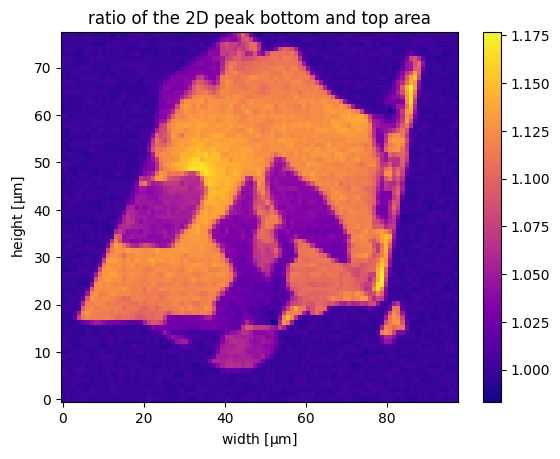

In [203]:
twod_ratio.plot(cmap = 'plasma')
pl.title('ratio of the 2D peak bottom and top area')

Putting in all together, let's do one more example of plotting the data. This will nicely show the power of `xarray`. Let's write a function that plots the Raman spectrum at a specified position on the map and plots the spectrum itself and the position on the map where it was measured.

In [226]:
def plotspec(xrobject, width, height):
    # Selecting the values for the spectrum
    spec = xrobject.sel(width = width, height = height, method = 'nearest')
    
    # We need to plot something on the density map, let's select the sum signal at the bottom of the 2D peak
    twod_bottom = xrobject.sel(ramanshift = slice(2650, 2715)) - 800
    twod_bottom = twod_bottom.sum(dim = 'ramanshift')
    twod_top = xrobject.sel(ramanshift = slice(2715, 2780)) - 800
    twod_top = twod_top.sum(dim = 'ramanshift')
    twod_ratio = twod_top / twod_bottom
    
    # Creating a figure with two subplots and a given size
    fig, [ax0, ax1] = pl.subplots(1, 2, figsize = (9, 4))
    # plotting the density plot of the 2D peak area ratio
    twod_ratio.plot(ax = ax0, cmap = 'plasma')
    # plotting the spectrum at the given coordinates on the right plot
    spec.plot(ax = ax1, color = 'lime')
    # plotting a dot on the density map, where the selected spectrum was measured
    ax0.scatter(width, height, color = 'lime', marker = 'x')
    pl.tight_layout()

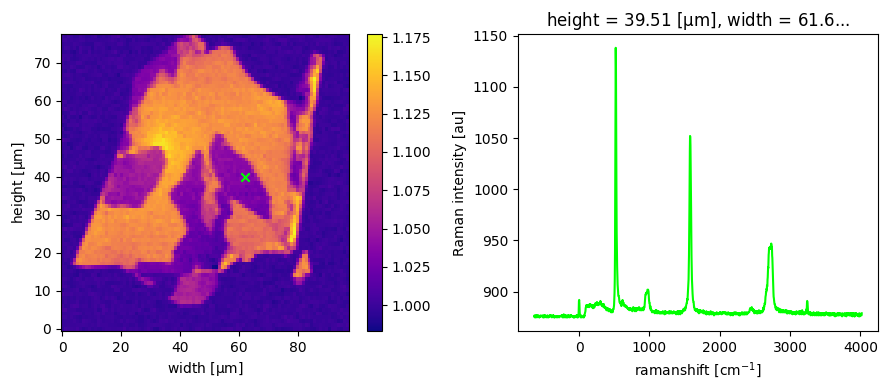

In [217]:
plotspec(ramanxr, 62, 40)

There is one problem with the above function. It plots the spectrum position at the value specified in the function variables. However, this is not the exact position of the coorfinate. This is selected by the `'nearest'` method of `sel()`. We can acces this in the following way.

In [225]:
spectrum = ramanxr.sel(width = 40, height = 30, method = 'nearest')
spectrum.coords['height'].data

array(30.39473684)

Let's rewrite the above function to tak account of this.

In [227]:
def plotspec(xrobject, width, height):
    # Selecting the values for the spectrum
    spec = xrobject.sel(width = width, height = height, method = 'nearest')
    
    # We need to plot something on the density map, let's select the sum signal at the bottom of the 2D peak
    twod_bottom = xrobject.sel(ramanshift = slice(2650, 2715)) - 800
    twod_bottom = twod_bottom.sum(dim = 'ramanshift')
    twod_top = xrobject.sel(ramanshift = slice(2715, 2780)) - 800
    twod_top = twod_top.sum(dim = 'ramanshift')
    twod_ratio = twod_top / twod_bottom
    
    # Creatinga figure with two subplots and a given size
    fig, [ax0, ax1] = pl.subplots(1, 2, figsize = (9, 4))
    # plotting the density plot of the 2D peak area ratio
    twod_ratio.plot(ax = ax0, cmap = 'plasma')
    # plotting the spectrum at the given coordinates on the right plot
    spec.plot(ax = ax1, color = 'lime')
    # plotting a dot on the density map, where the selected spectrum was measured
    # plotting the exact coordinates of the selected spectrum
    ax0.scatter(
        spec.coords['width'].data,
        spec.coords['height'].data,
        color = 'lime', marker = 'x')
    pl.tight_layout()

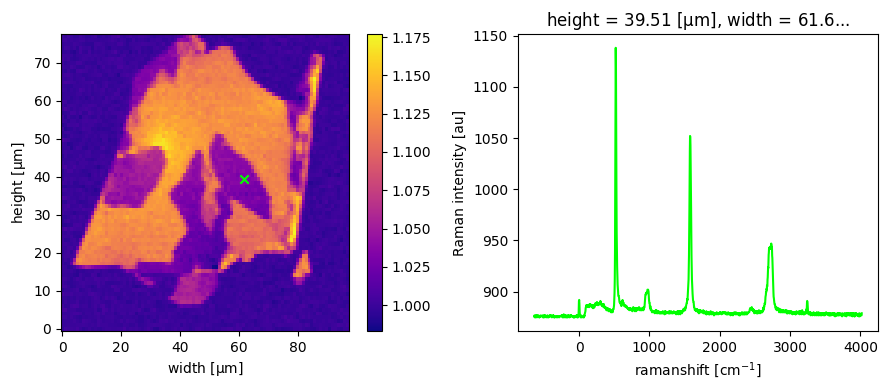

In [228]:
plotspec(ramanxr, 62, 40)

Listing the attributes of the DataArray.

In [229]:
ramanxr.attrs

{'units': 'au',
 'sample name': 'MK_FLG_ABC_36',
 'laser excitation': '487.986 nm',
 'time of measurement': '14:16:33',
 'date of measurement': '2023. május 25., csütörtök',
 'integration time': '0.5 s',
 'sample positioner X': -1470.0,
 'sample positioner Y': 1170.6,
 'objective name': 'Zeiss EC Epiplan-Neofluar Dic 50x / 0.8',
 'objective magnification': '50.0x',
 'grating': 'G1: 600 g/mm BLZ=500nm',
 'label': 'Raman intensity',
 'values': 'Raman intensity',
 'long_name': 'Raman intensity'}